# Biodiversity in National Parks - Codecademy Dataset

### Exploratory Data Analysis

***Imports & graphics settings***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats as st

%matplotlib inline

In [46]:
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.titlesize': 12,
    'legend.fontsize': 16,
})

In [43]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

***Analysis***

In [3]:
species = pd.read_csv('species_info.csv')
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [4]:
observations = pd.read_csv('observations.csv')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


There are duplicated samples with the same scientific name but different common names or vice versa

In [5]:
species.duplicated(subset=['scientific_name', 'common_names']).any()

True

However the conservation status for duplicates is not consistent

In [8]:
species.duplicated(subset=['scientific_name', 'common_names', 'conservation_status']).any()

False

In [9]:
species.loc[species.duplicated(subset=['scientific_name', 'common_names'])]

,category,scientific_name,common_names,conservation_status
3283,Fish,Oncorhynchus mykiss,Rainbow Trout,Threatened
4448,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered


So the problem is that there are two samples corresponding to the same animal with the same common_name and with one or more samples missing the conservation_satus feature. In this case the Nan value is really a missing value and does not correspond to what we will briefly call `No Concern`

In [10]:
species.loc[species.scientific_name=='Oncorhynchus mykiss']

,category,scientific_name,common_names,conservation_status
560,Fish,Oncorhynchus mykiss,Rainbow Trout,NaN
3283,Fish,Oncorhynchus mykiss,Rainbow Trout,Threatened


For canis lupus instead we have non matching common names and an inconsristen conservation status

In [11]:
species.loc[species.scientific_name=='Canis lupus']

,category,scientific_name,common_names,conservation_status
8,Mammal,Canis lupus,Gray Wolf,Endangered
3020,Mammal,Canis lupus,"Gray Wolf, Wolf",In Recovery
4448,Mammal,Canis lupus,"Gray Wolf, Wolf",Endangered


We remove duplicates

In [12]:
species.drop(index=[560, 3020, 4448], inplace=True)

In [13]:
df = species.merge(right=observations, how='outer', on='scientific_name',
                  indicator=True)
df.head()

,category,scientific_name,common_names,conservation_status,park_name,observations,_merge
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,Bryce National Park,130,both
1,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,Yellowstone National Park,270,both
2,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,Great Smoky Mountains National Park,98,both
3,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,Yosemite National Park,117,both
4,Mammal,Bos bison,"American Bison, Bison",NaN,Yosemite National Park,128,both


In [14]:
df._merge.unique()

['both']
Categories (1, object): ['both']

In [15]:
df.drop(columns='_merge', inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25600 entries, 0 to 25599
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             25600 non-null  object
 1   scientific_name      25600 non-null  object
 2   common_names         25600 non-null  object
 3   conservation_status  856 non-null    object
 4   park_name            25600 non-null  object
 5   observations         25600 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


As anticipated, now all NaN values correspond to the species representing no concern

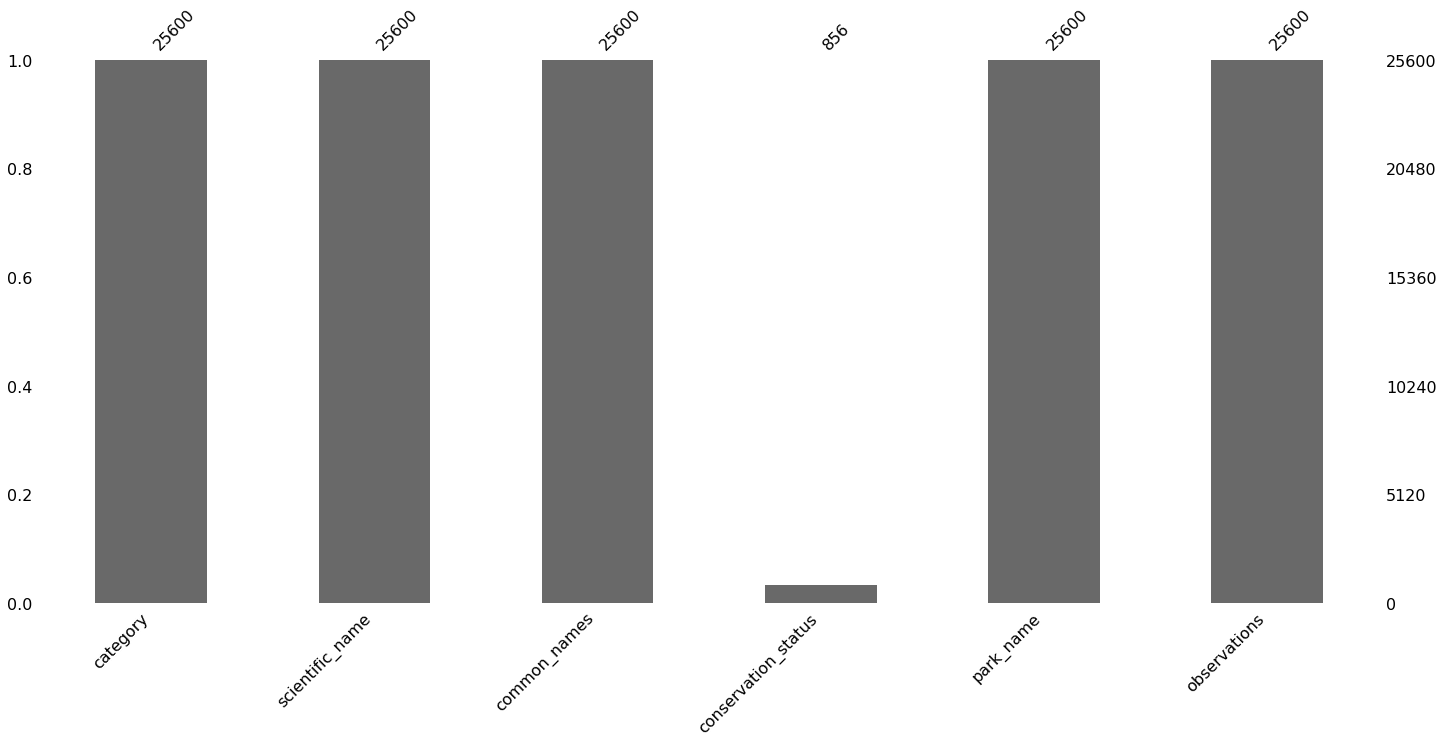

In [17]:
msno.bar(df)
plt.show()

In [18]:
df.isna().sum()

category                   0
scientific_name            0
common_names               0
conservation_status    24744
park_name                  0
observations               0
dtype: int64

In [19]:
df.conservation_status.unique()

array([nan, 'Species of Concern', 'Endangered', 'Threatened',
       'In Recovery'], dtype=object)

The remaining NA values correspond to `no concern`, so we rename them

In [20]:
df.conservation_status.replace(to_replace=np.nan, value='No Concern',
                              inplace=True)

In [21]:
# df.conservation_status = pd.Categorical(values=df.conservation_status,
#                categories=['No Concern', 'In Recovery', 'Species of Concern', 'Endangered', 'Threatened'],
#               ordered=True)

What is the distribution of severity of conservation risk across all species?

In [23]:
df.loc[df.conservation_status!='No Concern'].conservation_status.nunique()

4

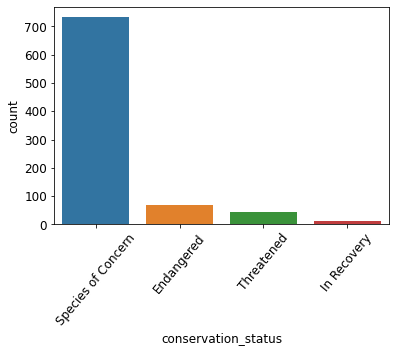

In [22]:
sns.countplot(data=df.loc[df.conservation_status!='No Concern'], x='conservation_status')
plt.xticks(rotation=50)
plt.show()

Let's filter only the species at risk for further analysis

In [24]:
endangered = df.loc[df.conservation_status!='No Concern']

In [25]:
endangered.head()

,category,scientific_name,common_names,conservation_status,park_name,observations
64,Mammal,Canis latrans,Coyote,Species of Concern,Bryce National Park,85
65,Mammal,Canis latrans,Coyote,Species of Concern,Yellowstone National Park,206
66,Mammal,Canis latrans,Coyote,Species of Concern,Great Smoky Mountains National Park,68
67,Mammal,Canis latrans,Coyote,Species of Concern,Yosemite National Park,99
68,Mammal,Canis lupus,Gray Wolf,Endangered,Yosemite National Park,35


In [26]:
endangered.conservation_status.value_counts()

Species of Concern    732
Endangered             68
Threatened             44
In Recovery            12
Name: conservation_status, dtype: int64

let's look at the observation for the endangered species

### observations by park

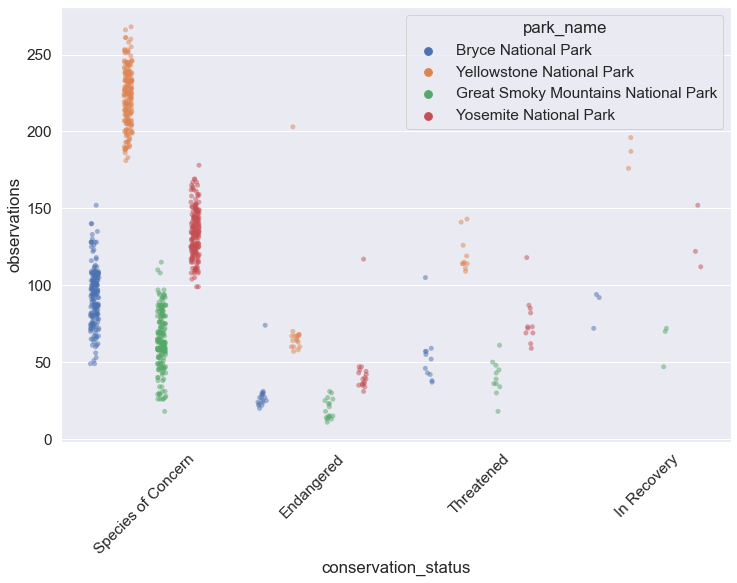

In [27]:
sns.set_theme(font_scale=1.4)
sns.stripplot(data=endangered, x='conservation_status', y='observations', hue='park_name', dodge=True, jitter=True, alpha=.5)
plt.gcf().set_size_inches(12, 8)
plt.xticks(rotation=45)
plt.show()

### overvall observations

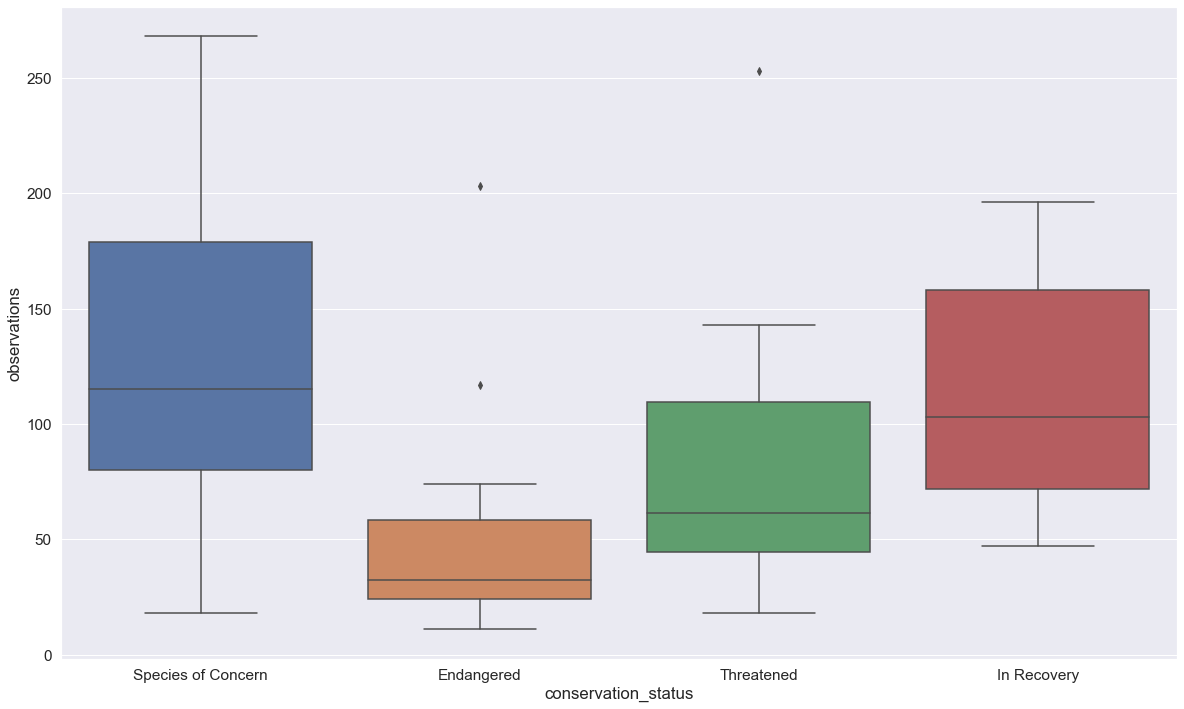

In [28]:
plt.figure(figsize=(20, 12))
sns.boxplot(data=endangered, x='conservation_status', y='observations')
plt.show()

In [30]:
endangered.category.unique()

array(['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant',
       'Nonvascular Plant'], dtype=object)

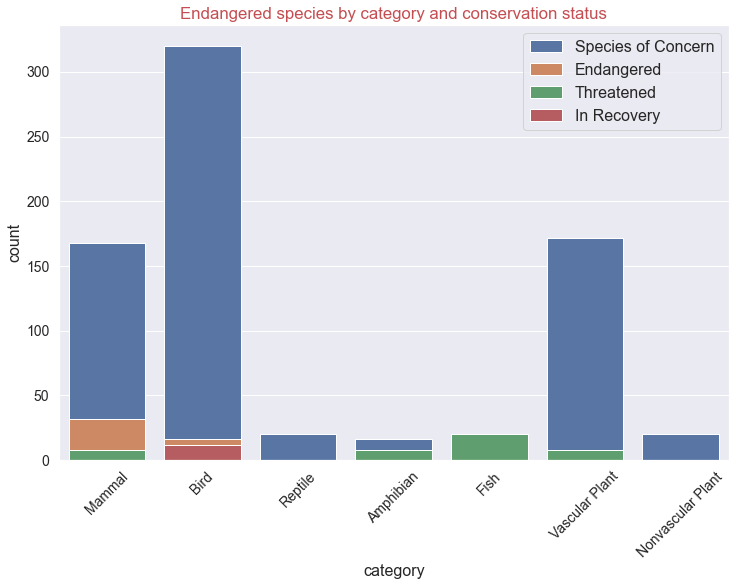

In [50]:
sns.countplot(data=endangered, x='category', hue='conservation_status', dodge=False)
plt.gcf().set_size_inches((12, 8))
plt.title('Endangered species by category and conservation status', c='r')
plt.legend(loc='upper right')
plt.gca().tick_params(axis='x', rotation=45)
plt.show()

Where are these species located?

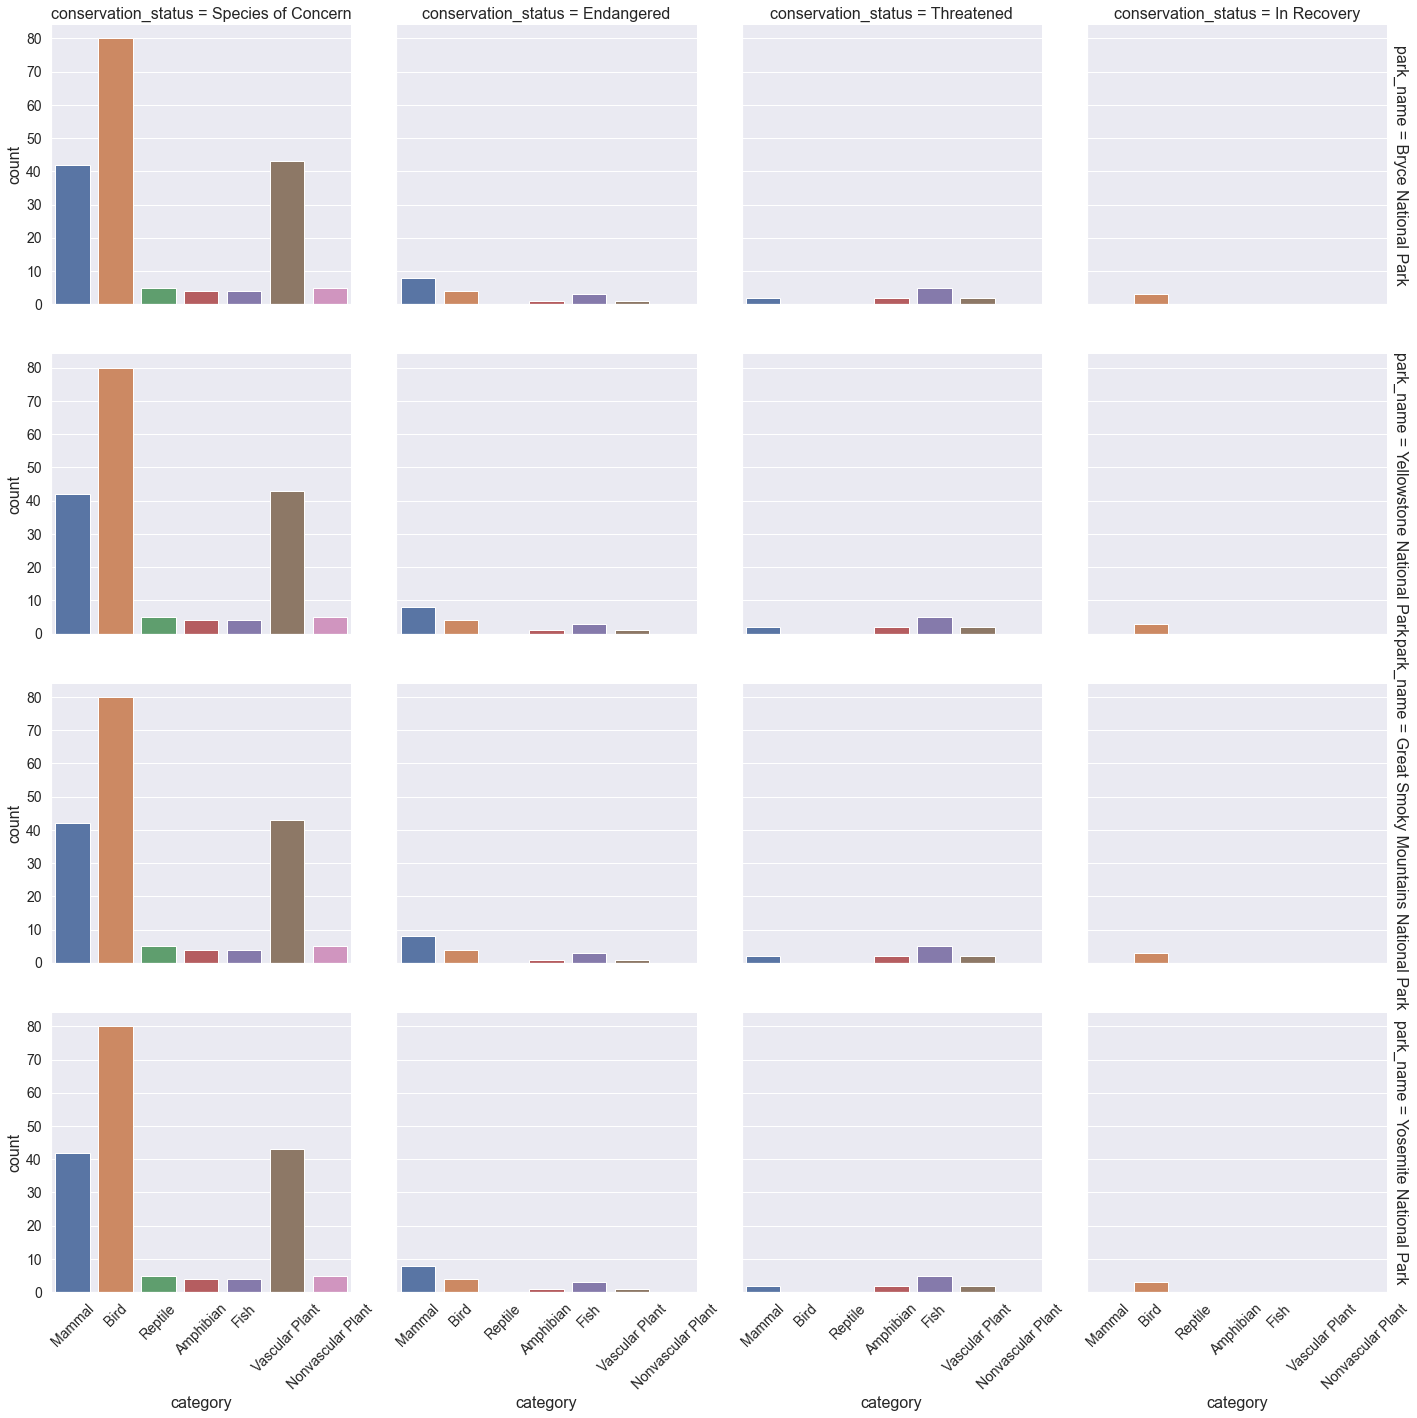

In [79]:
g = sns.catplot(data=endangered, x='category', col='conservation_status', row='park_name', kind='count',
               margin_titles=True, legend=True)
plt.xticks(rotation=45)
g._fig.set_size_inches((20, 20))
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()

As an useful interlude, little look into what fields we can access...

In [56]:
g.__dict__

{'_tight_layout_rect': [0, 0, 1, 1],
 '_tight_layout_pad': None,
 '_extract_legend_handles': False,
 '_n_facets': 16,
 '_col_wrap': None,
 '_ncol': 4,
 '_nrow': 4,
 '_fig': <Figure size 1440x1440 with 16 Axes>,
 '_axes': array([[<AxesSubplot:title={'center':'park_name = Bryce National Park | conservation_status = Species of Concern'}, ylabel='count'>,
         <AxesSubplot:title={'center':'park_name = Bryce National Park | conservation_status = Endangered'}>,
         <AxesSubplot:title={'center':'park_name = Bryce National Park | conservation_status = Threatened'}>,
         <AxesSubplot:title={'center':'park_name = Bryce National Park | conservation_status = In Recovery'}>],
        [<AxesSubplot:title={'center':'park_name = Yellowstone National Park | conservation_status = Species of Concern'}, ylabel='count'>,
         <AxesSubplot:title={'center':'park_name = Yellowstone National Park | conservation_status = Endangered'}>,
         <AxesSubplot:title={'center':'park_name = Yellows

------

Alternative visualisation with non shared x axis

/Users/Matthew/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


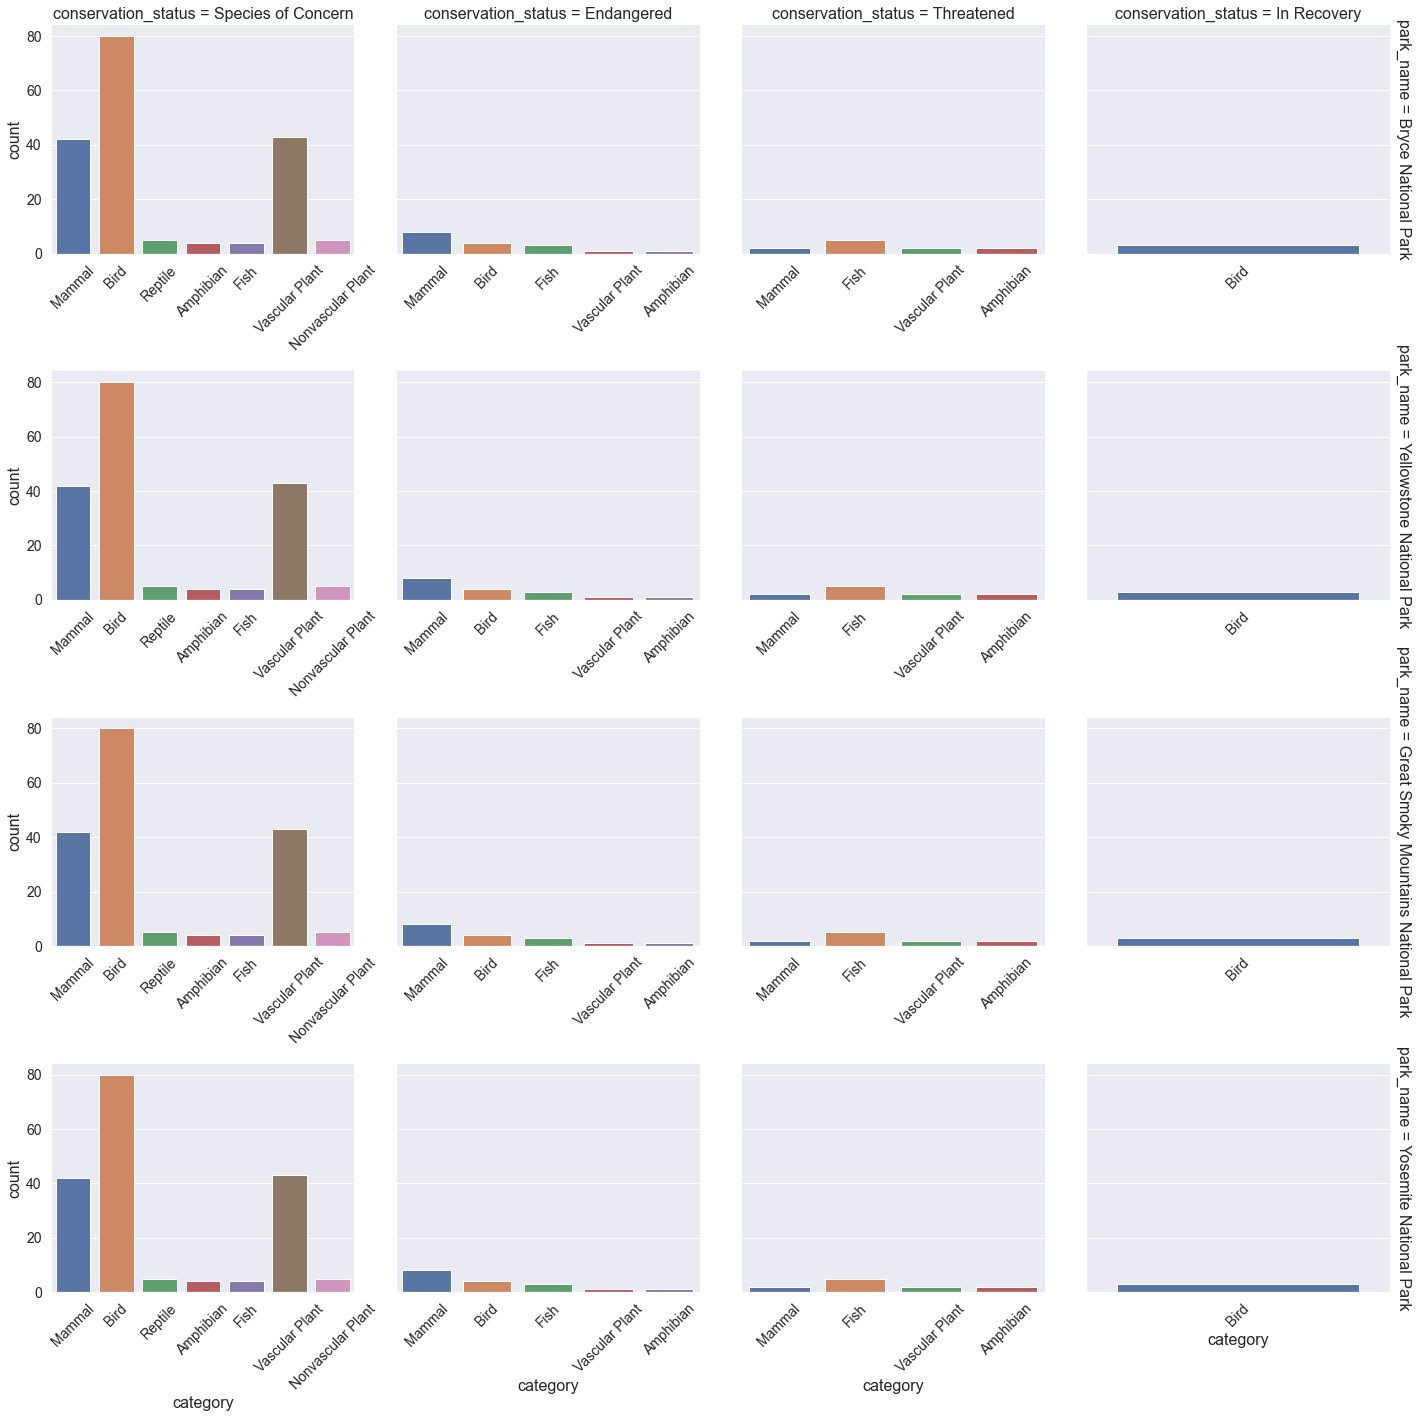

In [80]:
g = sns.catplot(data=endangered, x='category', col='conservation_status', row='park_name', kind='count',
               margin_titles=True, legend=True, sharex=False)
plt.xticks(rotation=45)
g.fig.set_size_inches((20, 20))
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()